# Exploratory Data Analysis of most viewed Youtube videos by a given search criteria

The project below is retrieving information about YouTube channels and their videos by a given topic. An interactive version of this project is available on https://bobiq-youtube-channe-youtube-channels-by-topic-streamlit-ncrahf.streamlit.app/ . 

The aim here is to provide a list of up to ten YT channels on a given topic. Users can enter the search criteria in the search box and the top 10 youtube channels will be returned together with the list of their videos. The user can then compare the channels' statistics such as the number of subscribers, viewers and likes as well as more specific data about videos such as the first and last publication, recent activity or most frequent tags, etc. Enjoy!

In [ ]:
import streamlit as st
import pandas as pd
import numpy as np
from dateutil import parser
import isodate
from datetime import datetime, timedelta 
import requests
import json
import os
# NLP libraries
from wordcloud import WordCloud
# Data visualization libraries
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.scale as mscale
import matplotlib.colors as mcolors
import seaborn as sns
# Google API
from googleapiclient.discovery import build
# functions from functions file
from functions import get_channel_stats, get_video_ids, get_video_details, get_comments_in_videos, get_youtube_channels


In [29]:
# remember to run export YOUTUBE_API_KEY="api_key code" or source .zshrc in Terminal
api_key = os.getenv('YOUTUBE_API_KEY')

youtube = build('youtube', 'v3', developerKey=api_key)

In [125]:
topic="wine tasting classes"
channel_ids = get_youtube_channels(api_key,topic,10)

channel_data = get_channel_stats(youtube, channel_ids)
channel_data = channel_data.rename(columns={'url': 'handle'})

# drop @ sign from the handle to create 'author' column
channel_data['author']=channel_data['handle'].str.replace('@','')
# create a url from the handle (url variable)
update_url = lambda x: f"www.youtube.com/{x}/about" if x.startswith("@") else x
# Apply the lambda function to the 'url' column
channel_data['link'] = channel_data['handle'].apply(update_url)

pd.set_option('display.max_colwidth', None)

In [126]:
    # Iterate over the rows and display channelName and link in the columns
for row in channel_data.itertuples():
  print(row.channelName,row.link)
 

Thrivingly www.youtube.com/@thrivinglyapp/about
bevinars www.youtube.com/@bevinars/about
Cree Wine Company www.youtube.com/@creewinecompany541/about
Wine & Spirit Education Trust (WSET) www.youtube.com/@wsetglobal/about
Millesiwine Paris www.youtube.com/@millesiwineparis4882/about
GoinItaly www.youtube.com/@goinitaly/about
Le Foodist Paris Cooking Classes Wine Tasting Food Tour and Pastry Classes www.youtube.com/@lefoodistparis/about
Savour Academy Barcelona www.youtube.com/@savouracademy/about
WineForNormalPeople www.youtube.com/@winefornormalpeople/about
FNBCLASSES www.youtube.com/@hemantkrsingh/about


In [61]:
# Convert count columns to numeric columns
numeric_cols = ['subscribers', 'views','totalVideos']
channel_data[numeric_cols] = channel_data[numeric_cols].apply(pd.to_numeric, errors='coerce')
channel_data['views_per_video']=channel_data['views']/channel_data['totalVideos']
channel_data['views_per_video'].astype('int')

4     9249
2      306
1     5000
5    17200
7     1416
6      230
0     1017
9       43
3      203
8       20
Name: views_per_video, dtype: int64

In [63]:
# Sort the channel_data DataFrame by 'subscribers' column in descending order
channel_data = channel_data.sort_values('subscribers', ascending=False)
channel_author_dict = channel_data[['channelName', 'author']].set_index('channelName').to_dict()['author']

In [64]:
# Create a list of pastel colors for the 'color' column
pastel_palette = sns.color_palette('pastel', n_colors=len(channel_data))

# Convert the colors to hexadecimal format
hex_palette = [mcolors.rgb2hex(color) for color in pastel_palette]

# Assign the pastel colors to the 'color' column based on the 'author' column
channel_data['color'] = hex_palette[:len(channel_data)]
author_color_map = dict(zip(channel_data['author'], channel_data['color']))
# Map the author names to their respective colors from author_color_map
channel_data['color'] = channel_data['author'].map(author_color_map).fillna(channel_data['color'])

In [65]:
# Sort the data for each graph
channel_data_subscribers = channel_data.sort_values('subscribers', ascending=False)
channel_data_views = channel_data.sort_values('views', ascending=False)
channel_data_total_videos = channel_data.sort_values('totalVideos', ascending=False)
channel_data_views_per_video = channel_data.sort_values('views_per_video', ascending=False)

In [66]:
channel_data

,channelName,handle,subscribers,views,totalVideos,playlistId,author,link,views_per_video,color
4,Wine & Spirit Education Trust (WSET),@wsetglobal,50800,3949432,427,UUu5KYXDbUqhaLfrq9Je6dJw,wsetglobal,www.youtube.com/@wsetglobal/about,9249.255269,#a1c9f4
2,WineForNormalPeople,@winefornormalpeople,3970,135170,441,UU6FXGlju1DczRaZleFC3XNA,winefornormalpeople,www.youtube.com/@winefornormalpeople/about,306.507937,#ffb482
1,FNBCLASSES,@hemantkrsingh,2130,125017,25,UUtEmIqoo7SW9iqEG1nM1s6w,hemantkrsingh,www.youtube.com/@hemantkrsingh/about,5000.680000,#8de5a1
5,Thrivingly,@thrivinglyapp,680,154804,9,UUjVlGkJV4xth5HZ6c6QiAfQ,thrivinglyapp,www.youtube.com/@thrivinglyapp/about,17200.444444,#ff9f9b
7,bevinars,@bevinars,448,286146,202,UUPC6Y0VysO21cxENaVGIFVA,bevinars,www.youtube.com/@bevinars/about,1416.564356,#d0bbff
6,Millesiwine Paris,@millesiwineparis4882,198,12224,53,UUBf59CRt1KvC2RN0siVxhsQ,millesiwineparis4882,www.youtube.com/@millesiwineparis4882/about,230.641509,#debb9b
0,Le Foodist Paris Cooking Classes Wine Tasting Food Tour and Pastry Classes,@lefoodistparis,94,11191,11,UUmY9hawCpUy2ATIQiVZ2mhA,lefoodistparis,www.youtube.com/@lefoodistparis/about,1017.363636,#fab0e4
9,Agustivino,@agustivino296,9,344,8,UUme8wWgyqXmSeCAez_y_FjA,agustivino296,www.youtube.com/@agustivino296/about,43.000000,#cfcfcf
3,Cree Wine Company,@creewinecompany541,7,611,3,UUsDPpIfGOj44Hat3sO0bexQ,creewinecompany541,www.youtube.com/@creewinecompany541/about,203.666667,#fffea3
8,Savour Academy Barcelona,@savouracademy,0,41,2,UUqjvzkBjUx6FcDp_1MTKy7g,savouracademy,www.youtube.com/@savouracademy/about,20.500000,#b9f2f0


## Graph 1: Number of subscribers per author

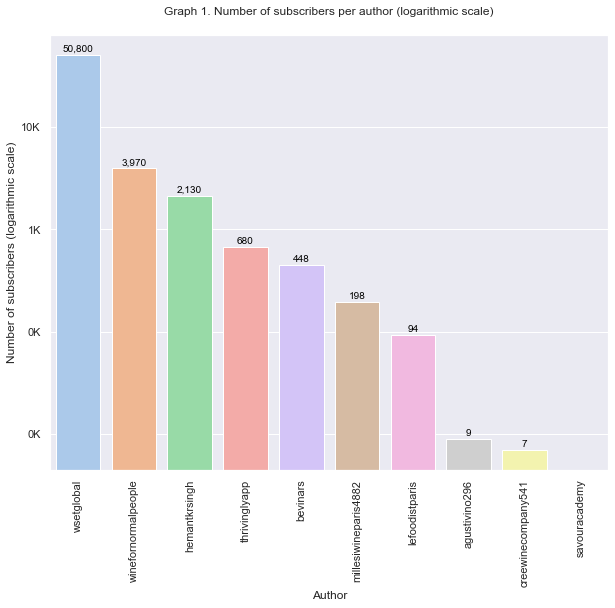

In [114]:
sns.set(rc={'figure.figsize':(10,8)})
fig1, ax1 = plt.subplots()
# plt.figure(figsize=figure_size)
sns.barplot(x='author', y='subscribers', data=channel_data_subscribers, palette=author_color_map, ax=ax1)
ax1.set_yscale('log')
# ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'K'))
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}K'.format(x/1000)))

ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
ax1.set_xlabel('Author')
ax1.set_ylabel('Number of subscribers (logarithmic scale)')
ax1.set_title('Graph 1. Number of subscribers per author (logarithmic scale)', pad=20)
for p in ax1.patches:
    ax1.annotate(f'{p.get_height():,.0f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='baseline', fontsize=10, color='black', xytext=(0, 3), textcoords='offset points')
plt.show() 

## Graph 2: Number of YouTube video views per author

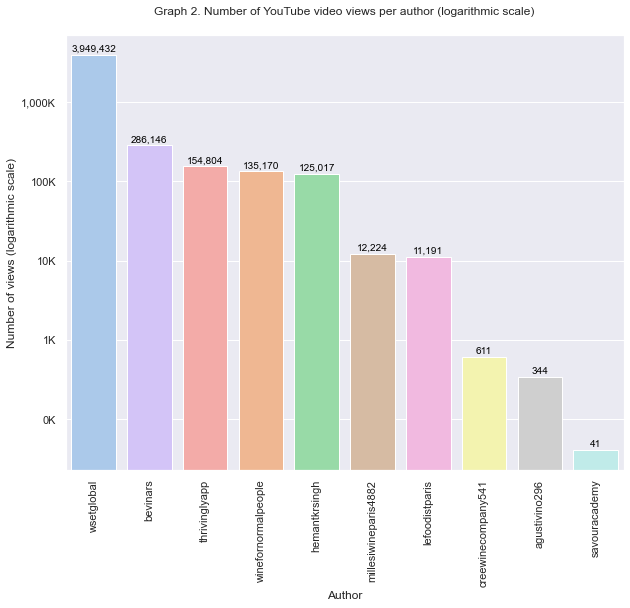

In [115]:
fig2, ax2 = plt.subplots()
# plt.figure(figsize=figure_size)
sns.barplot(x='author', y='views', data=channel_data_views, palette=author_color_map, ax=ax2)
ax2.set_yscale('log')
# ax2.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'K'))
ax2.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}K'.format(x/1000)))

ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)
ax2.set_xlabel('Author')
ax2.set_ylabel('Number of views (logarithmic scale)')
ax2.set_title('Graph 2. Number of YouTube video views per author (logarithmic scale)', pad=20)
for p in ax2.patches:
    ax2.annotate(f'{p.get_height():,.0f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='baseline', fontsize=10, color='black', xytext=(0, 3), textcoords='offset points')
plt.show() 

## Graph 3: Number of YouTube videos per author

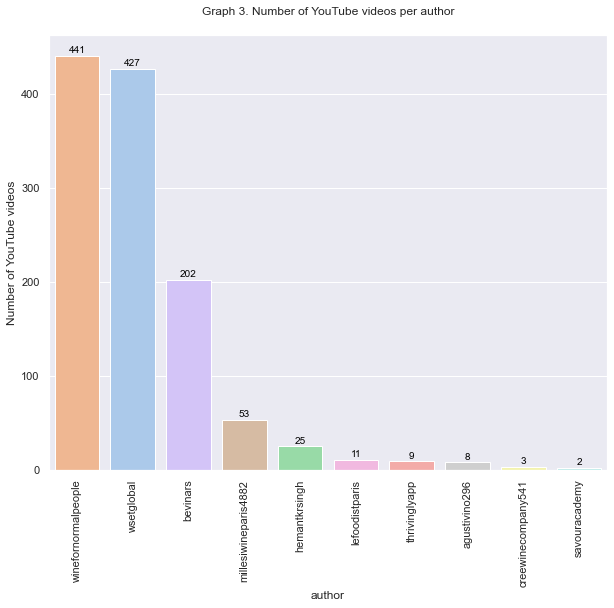

In [116]:
fig3, ax3 = plt.subplots()
# plt.figure(figsize=figure_size)
sns.barplot(x='author', y='totalVideos', data=channel_data_total_videos, palette=author_color_map, ax=ax3)
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=90)
ax3.set_xlabel('author')
ax3.set_title('Graph 3. Number of YouTube videos per author', pad=20)
ax3.set_ylabel('Number of YouTube videos')
for p in ax3.patches:
    ax3.annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='baseline', fontsize=10, color='black', xytext=(0, 3), textcoords='offset points')
plt.show() 

## Graph 4: Views per video by author

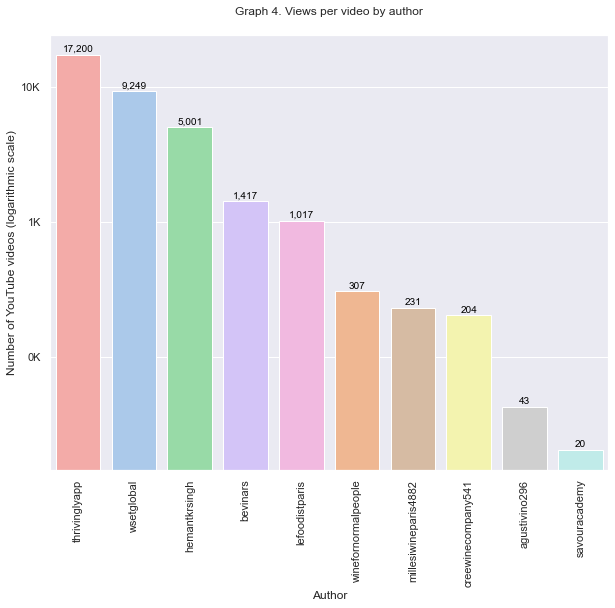

In [118]:
fig4, ax4 = plt.subplots()
# plt.figure(figsize=figure_size)
sns.barplot(x='author', y='views_per_video', data=channel_data_views_per_video, palette=author_color_map, ax=ax4)
ax4.set_yscale('log')
# ax4.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'K'))
ax4.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}K'.format(x/1000)))

ax4.set_xticklabels(ax4.get_xticklabels(), rotation=90)
ax4.set_xlabel('Author')
ax4.set_title('Graph 4. Views per video by author', pad=20)
ax4.set_ylabel('Number of YouTube videos (logarithmic scale)')
for p in ax4.patches:
    ax4.annotate(f'{p.get_height():,.0f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='baseline', fontsize=10, color='black', xytext=(0, 3), textcoords='offset points')

plt.show() 

### Below we download the videos data, perform some data cleaning and create some additional data features.

In [67]:
video_df = pd.DataFrame()

for c in channel_data['channelName'].unique():
    print("Getting video information from channel: " + c)
    playlist_id = channel_data.loc[channel_data['channelName']== c, 'playlistId'].iloc[0]
    video_ids = get_video_ids(youtube, playlist_id)
    video_data = get_video_details(youtube, video_ids)
    video_df = pd.concat([video_df, video_data], ignore_index=True)

video_df['author'] = video_df['channelTitle'].map(channel_author_dict)
video_df=video_df.set_index('video_id')
video_df['commentCount'].fillna(0, inplace=True)
cols = ['viewCount', 'likeCount', 'commentCount']
video_df[cols] = video_df[cols].apply(pd.to_numeric, errors='coerce', axis=1)
# Create publish day (in the week) column
video_df['publishedAt'] =  video_df['publishedAt'].apply(lambda x: parser.parse(x)) 
video_df['publishDayName'] = video_df['publishedAt'].apply(lambda x: x.strftime("%A")) 

# Add number of tags
video_df['tagsCount'] = video_df['tags'].apply(lambda x: 0 if x is None else len(x))

# Comments and likes per 100 view ratio
video_df['likeRatio'] = video_df['likeCount']/ video_df['viewCount'] * 100
video_df['commentRatio'] = video_df['commentCount']/ video_df['viewCount'] * 100



Getting video information from channel: Wine & Spirit Education Trust (WSET)
Getting video information from channel: WineForNormalPeople
Getting video information from channel: FNBCLASSES
Getting video information from channel: Thrivingly
Getting video information from channel: bevinars
Getting video information from channel: Millesiwine Paris
Getting video information from channel: Le Foodist Paris Cooking Classes Wine Tasting Food Tour and Pastry Classes
Getting video information from channel: Agustivino
Getting video information from channel: Cree Wine Company
Getting video information from channel: Savour Academy Barcelona


In [68]:
# convert duration to seconds
video_df['durationSecs'] = video_df['duration'].apply(lambda x: isodate.parse_duration(x))
video_df['durationSecs'] = video_df['durationSecs'].astype('timedelta64[s]')
video_df['durationMins'] = video_df['durationSecs']/60
# Title character length
video_df['titleLength'] = video_df['title'].apply(lambda x: len(x))
video_df['likes_per_second']=video_df['likeCount']/video_df['durationSecs']
today = datetime.datetime.now().date()
# Calculate the number of days since 'publishedAt' until today
video_df['days_since_published'] = (today - video_df['publishedAt'].dt.date).dt.days
video_df['avg_likes_pd_since_published']=video_df['likeCount']/video_df['days_since_published']
video_df['avg_views_pd_since_published']=video_df['viewCount']/video_df['days_since_published']

## Graph 5. Combined length of YouTube videos per author

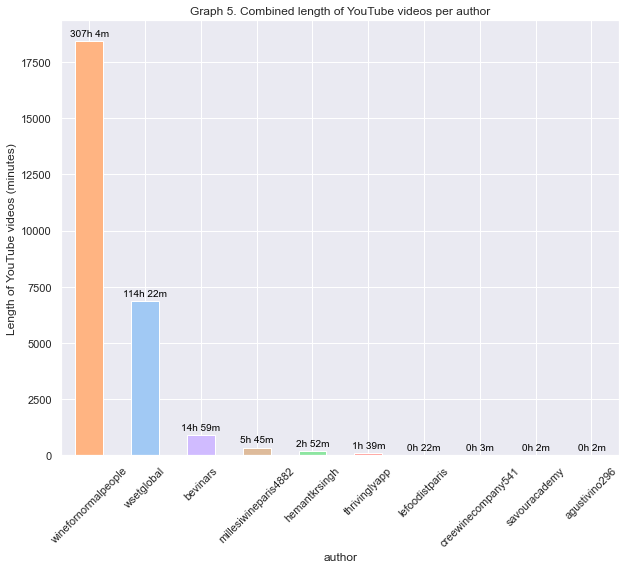

In [72]:
fig5, ax5 = plt.subplots()
ax5 = sum_duration_min.plot(kind='bar', rot= 45,color=[author_color_map[a] for a in sum_duration_min.index])
# ax = sum_duration_min.plot(kind='bar', x='author', y='likes_per_second', color=[author_color_map[a] for a in sum_duration_min['author']])
for p in ax5.patches:
    # Get the duration in minutes
    duration_min = p.get_height()
    # print(duration_min)
    # Convert the duration to hours and minutes
    duration_hr = int(duration_min // 60)
    duration_min = int(duration_min % 60)
    # Format the duration as a string
    duration_str = f'{duration_hr}h {duration_min}m'

    # Add the annotation to the plot
    ax5.annotate(
        duration_str,
        xy=(p.get_x() + p.get_width() / 2., p.get_height()), 
        ha='center', 
        va='bottom', 
        fontsize=10, 
        color='black',
        xytext=(0, 3),
        textcoords='offset points'
    )

ax5.set_xlabel('author')
ax5.set_ylabel('Length of YouTube videos (minutes)')
ax5.set_title('Graph 5. Combined length of YouTube videos per author')
plt.show()

## Graph 6. Average length of a YouTube video per author'

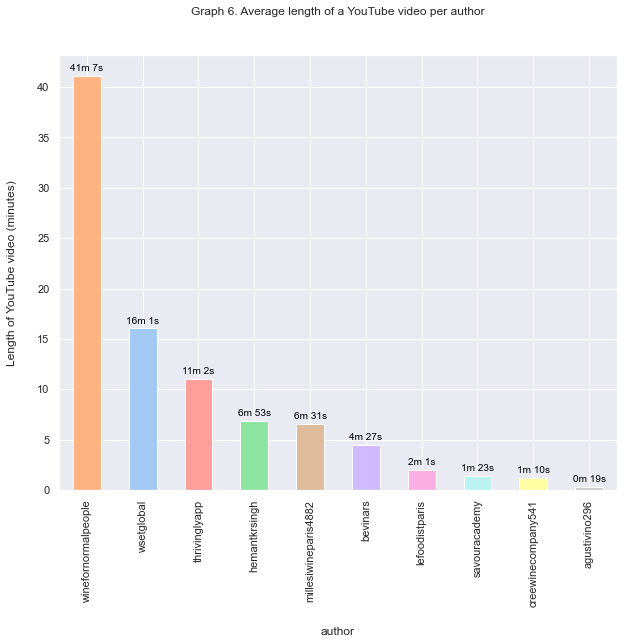

In [76]:
# Group the video data by author and calculate the mean duration
mean_duration_min = video_df.groupby('author')['durationMins'].mean()

# Sort the mean_duration_min Series by the order of the authors in the author_color_map dictionary
mean_duration_min = mean_duration_min.loc[list(author_color_map.keys())]
mean_duration_min = mean_duration_min.sort_values(ascending = False)
# Create a list of colors based on the sorted mean_duration_min Series
colors = [author_color_map[a] for a in mean_duration_min.index]
# Create the bar plot with the specified colors
ax6 = mean_duration_min.plot(kind='bar', rot=90, color=colors)
# Add values on top of each bar
for index, value in enumerate(mean_duration_min):
    minutes = int(value)
    seconds = int((value - minutes) * 60)
    ax6.annotate(
        f'{minutes}m {seconds}s',
        xy=(index, value),
        ha='center',
        va='bottom',
        fontsize=10,
        color='black',
        xytext=(0, 3),
        textcoords='offset points'
    )

ax6.set_xlabel('author',labelpad=20)
ax6.set_ylabel('Length of YouTube video (minutes)',labelpad=20)
ax6.set_title('Graph 6. Average length of a YouTube video per author', pad=40)
plt.show()
  

### The Wordclouds for each channel below allow to identify the ones with the content of most interest to us. Videos wrongly tagged usually lead to low levels of recommendation by the YT algorithm so this will work with channels that are viewed more frequently.


No tags available for agustivino296


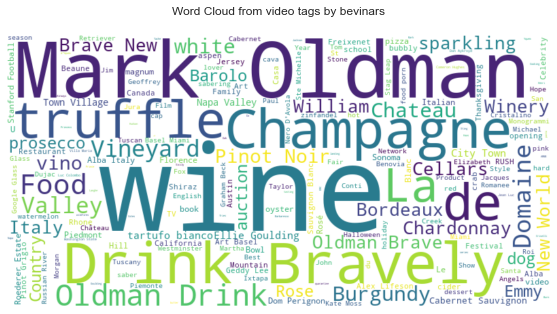

No tags available for creewinecompany541


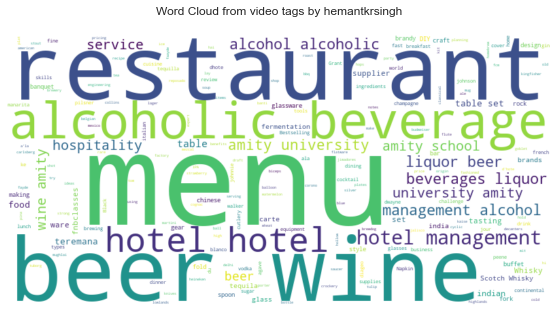

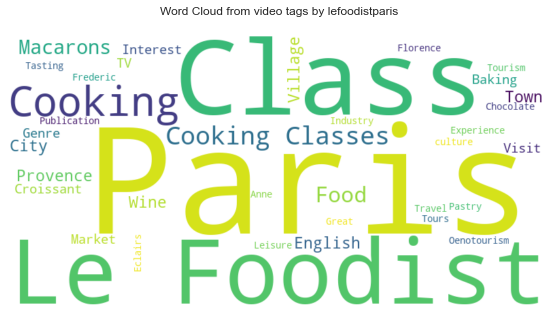

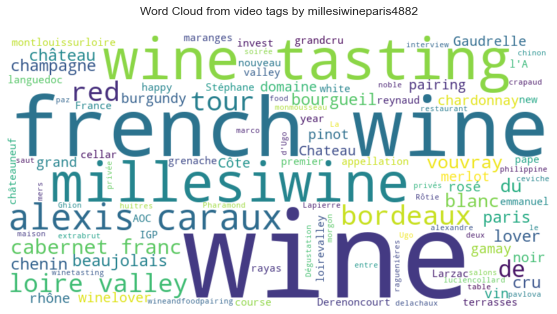

No tags available for savouracademy


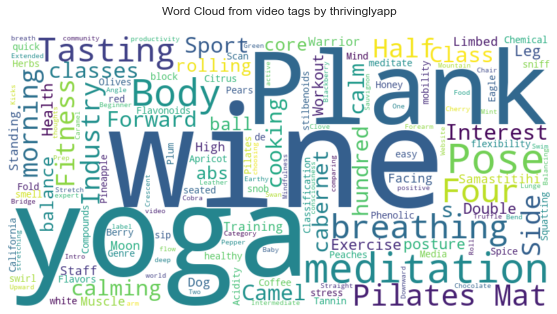

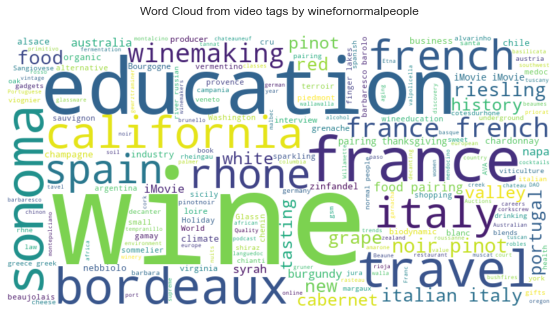

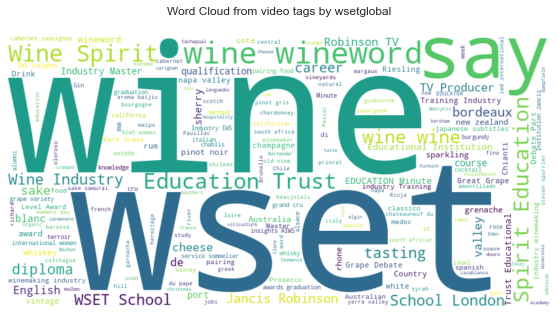

In [83]:
authors = video_df['author'].unique()
tags_by_author = video_df.groupby('author')['tags'].apply(lambda x: ' '.join([tag for tags in x if tags is not None for tag in tags if tag])).reset_index()

for author, tags in zip(tags_by_author['author'], tags_by_author['tags']):
    try:
        # Create a WordCloud object
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(tags)
        
        # Create a new figure and axes for each word cloud
        fig, ax = plt.subplots(figsize=(10, 5))
        
        # Plot the word cloud on the axes
        ax.imshow(wordcloud, interpolation='bilinear')
        ax.set_title(f'Word Cloud from video tags by {author}', pad=20)
        ax.axis('off')
        
        # Show the word cloud using st.pyplot()
        plt.show()
    
    except ValueError:
        # Handle the ValueError when no words are present for a specific author
        print(f"No tags available for {author}")

### The following table provides information about channel's recent activity

In [106]:
first_video_date = video_df.groupby('author')['publishedAt'].min().dt.date.sort_values()
last_video_date = video_df.groupby('author')['publishedAt'].max().dt.date.sort_values()

# total_days = video_df.groupby('author')['days_since_published'].sum()
first_last_published_dates = pd.concat([first_video_date, last_video_date], axis=1)
first_last_published_dates.columns=['First video published','Last video published']

# Calculate the date 30 days ago
date_30_days_ago = datetime.now().date() - timedelta(days=30)

# Filter the videos posted in the last 30 days
videos_last_30_days = video_df[video_df['publishedAt'].dt.date >= date_30_days_ago]

# Group the filtered videos by author and count the number of videos
num_videos_last_30_days = videos_last_30_days.groupby('author').size().rename('Videos in the last 30 Days')

# Merge the new column with the existing DataFrame
first_last_published_dates = pd.concat([first_last_published_dates, num_videos_last_30_days], axis=1)
first_last_published_dates['Videos in the last 30 Days']=first_last_published_dates['Videos in the last 30 Days'].fillna(0).astype('int')
print(first_last_published_dates)

                     First video published Last video published  \
author                                                            
wsetglobal                      2008-12-04           2023-05-10   
bevinars                        2010-08-21           2023-02-21   
winefornormalpeople             2012-06-12           2023-05-15   
thrivinglyapp                   2014-11-15           2014-11-15   
lefoodistparis                  2014-11-24           2019-12-16   
millesiwineparis4882            2016-09-19           2022-06-02   
hemantkrsingh                   2020-06-27           2023-03-01   
creewinecompany541              2021-02-11           2022-11-05   
agustivino296                   2021-07-11           2022-01-25   
savouracademy                   2023-04-28           2023-04-28   

                      Videos in the last 30 Days  
author                                            
wsetglobal                                     1  
bevinars                                  

## Graph 7. Average number of likes per 100 views  per author 

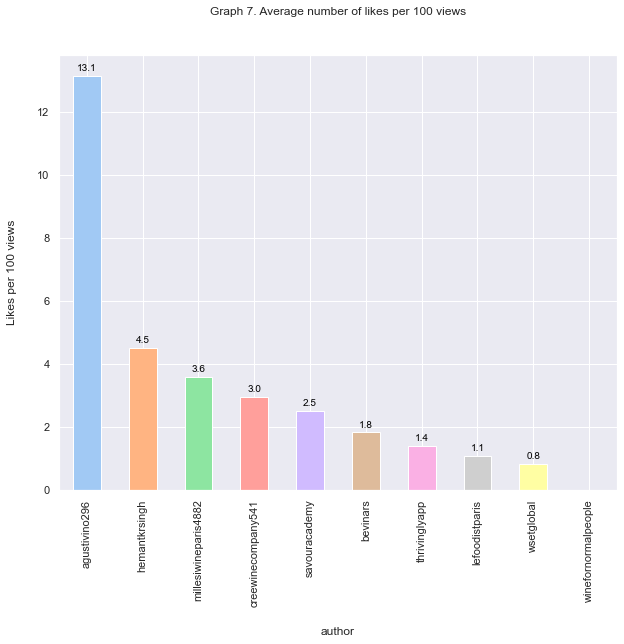

In [107]:
# Group the video data by author and calculate the mean duration
mean_likeRatio = video_df.groupby('author')['likeRatio'].mean()

# Sort the mean_duration_min Series by the order of the authors in the author_color_map dictionary
mean_likeRatio = mean_likeRatio.loc[list(author_color_map.keys())]

# Create a list of colors based on the sorted mean_duration_min Series
colors = [author_color_map[a] for a in mean_likeRatio.index]

mean_likeRatio=mean_likeRatio.sort_values(ascending = False)

fig7, ax7 = plt.subplots()
    # plt.figure(figsize=figure_size)
    # Create the bar plot with the specified colors
ax7 = mean_likeRatio.plot(kind='bar', rot=90, color=colors)

# Add values on top of each bar
for index, value in enumerate(mean_likeRatio):
    ax7.annotate(
        f'{value:.1f}',
        xy=(index, value),
        ha='center',
        va='bottom',
        fontsize=10,
        color='black',
        xytext=(0, 3),
        textcoords='offset points'
    )

ax7.set_xlabel('author',labelpad=20)
ax7.set_ylabel('Likes per 100 views',labelpad=20)
ax7.set_title('Graph 7. Average number of likes per 100 views', pad=40)
plt.show()

## Graph 8. Most liked video by each author

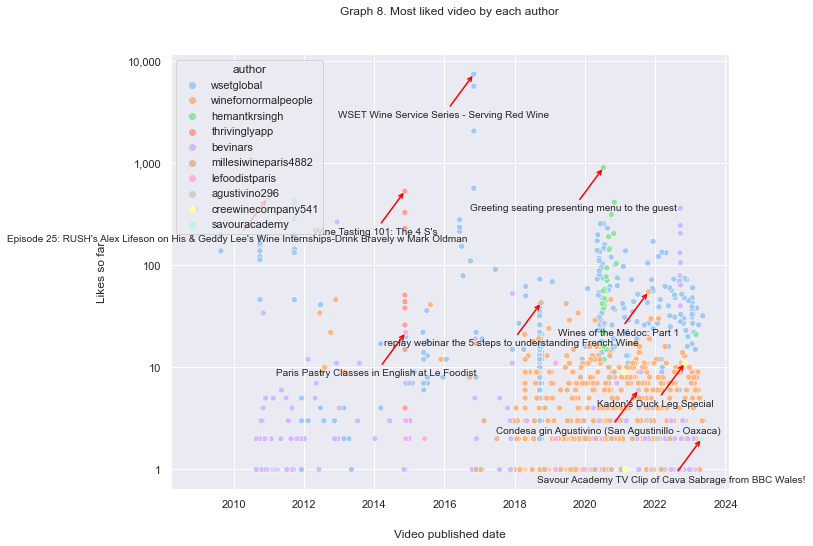

In [123]:

fig8, ax8 = plt.subplots()
    # plt.figure(figsize=figure_size)
    # Graph 8. Most liked song by each author'
ax8 = sns.scatterplot(data=video_df, x='publishedAt', y='likeCount', hue='author',palette=author_color_map)
ax8.set_yscale('log')
ax8.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))

plt.ylabel("Likes so far",labelpad=20)
plt.xlabel("Video published date",labelpad=20)

for author in video_df['author'].unique():
    author_data = video_df[video_df['author'] == author]
    max_likes = author_data['likeCount'].max()
    
    if not author_data.empty and max_likes is not None:
        max_likes_video = author_data[author_data['likeCount'] == max_likes].iloc[0]
        
        ax8.annotate(max_likes_video['title'],
                    xy=(max_likes_video['publishedAt'], max_likes_video['likeCount']),
                    xycoords='data',
                    xytext=(-30, -45),
                    textcoords='offset points',
                    arrowprops=dict(arrowstyle='->', lw=1.5, color='red'),
                    fontsize=10,
                    ha='center',
                    va='bottom')

ax8.set_title('Graph 8. Most liked video by each author', pad=40)
plt.show()


## Graph 9. Views vs likes per day since published

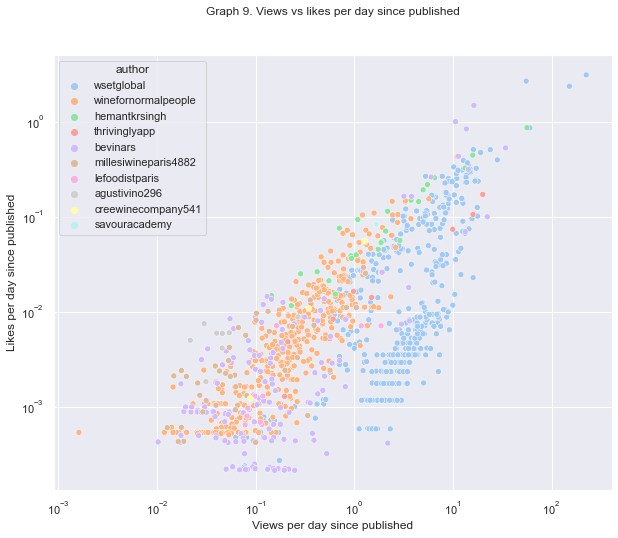

In [110]:
fig9, a9 = plt.subplots()
st.text("In this plot each dot is a video and we can see on x axis the likes it received on average every day since published. On y axis - the average views per day since published. ")
ax9=sns.scatterplot(data=video_df,x='avg_views_pd_since_published',y='avg_likes_pd_since_published',hue='author', palette=author_color_map)
ax9.set_xscale('log')
ax9.set_yscale('log')
ax9.set_xlabel('Views per day since published')
ax9.set_ylabel('Likes per day since published')
ax9.set_title('Graph 9. Views vs likes per day since published', pad=40)
plt.show()


References/ Resources used:

[1] Youtube API. Avaiable at https://developers.google.com/youtube/v3

[2] This project has been inspired by the video by Thu Vu https://youtu.be/D56_Cx36oGY